In [8]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt


In [9]:
df=pd.read_csv('Data/USA_Housing.csv')
df_copy=df.copy()

In [10]:
df_copy.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.06718,5.865890,8.512727,5.13,36882.15940,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.24005,7.188236,5.586729,3.26,34310.24283,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.19723,5.040555,7.839388,4.23,26354.10947,6.309435e+05,USNS Raymond\nFPO AE 09386


# ***DataPreprocessing***

#### **Null Data Percentage wise**

In [13]:
(df_copy.isnull().sum()/len(df_copy))* 100

Avg. Area Income                0.20
Avg. Area House Age             0.00
Avg. Area Number of Rooms       0.10
Avg. Area Number of Bedrooms    0.12
Area Population                 0.00
Price                           0.00
Address                         0.00
dtype: float64

#### **Identify Outlier For Applying Imputation Method**

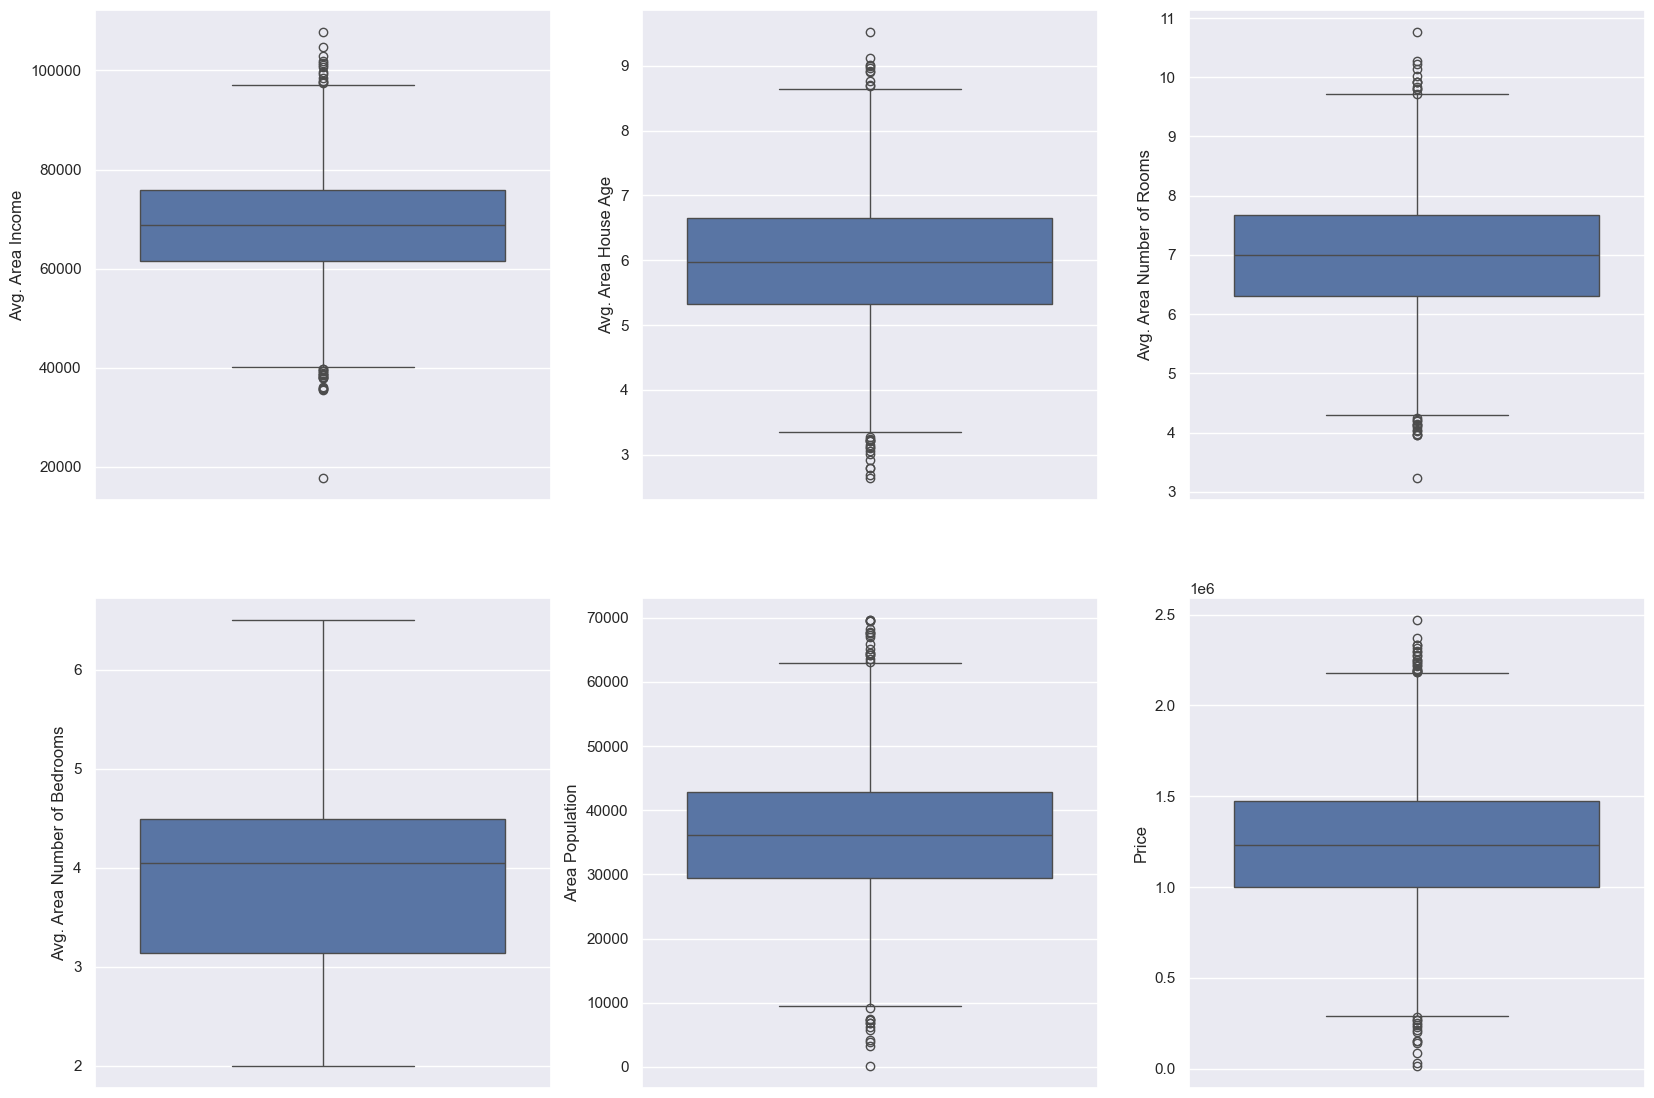

In [40]:
plt.figure(figsize=(20,14))
for i,j in enumerate(df_copy.select_dtypes(exclude='object')):
    plt.subplot(2,3,i+1)
    sns.boxplot(data=df_copy[df_copy.select_dtypes(exclude='object').columns[i]])
   

In [18]:
df_copy.select_dtypes(exclude='object')

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1.059034e+06
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1.505891e+06
2,61287.06718,5.865890,8.512727,5.13,36882.15940,1.058988e+06
3,63345.24005,7.188236,5.586729,3.26,34310.24283,1.260617e+06
4,59982.19723,5.040555,7.839388,4.23,26354.10947,6.309435e+05
...,...,...,...,...,...,...
4995,60567.94414,7.830362,6.137356,3.46,22837.36103,1.060194e+06
4996,78491.27543,6.999135,6.576763,4.02,25616.11549,1.482618e+06
4997,63390.68689,7.250591,4.805081,2.13,33266.14549,1.030730e+06
4998,68001.33124,5.534388,7.130144,5.44,42625.62016,1.198657e+06
